# Manual Capacity Planning Tool for Germany

This notebook provides an interactive tool to model capacity expansion scenarios from 2025 (baseline) to 2033 for Germany. 

## Key Concepts

**Load Duration Curve (LDC)**: A curve that sorts demand or residual load from highest to lowest, showing:
- How many hours the system operates at different load levels
- Peak vs baseload requirements
- Used to identify capacity gaps

**Residual Load**: Demand minus variable renewable generation (solar, wind)
- This is what dispatchable capacity (gas, hydro, storage) needs to meet
- When residual load > dispatchable capacity = potential shortage

## Workflow

1. Start with 2025 baseline generation capacity
2. Set 2033 capacity targets (e.g., retire coal, add renewables)
3. Analyze residual load duration curves across climatic years
4. Identify shortfalls and iterate on capacity mix


In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# For interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Data paths
DATA_DIR = Path('/Users/dh/development/electricsystemplanning-2025-europe_two/data/ERAA_2023-2')
DEMAND_DIR = DATA_DIR / 'demand'
CAPA_FACTOR_DIR = DATA_DIR / 'res_capa-factors'
GEN_CAPA_DIR = DATA_DIR / 'generation_capas'

print("✓ Setup complete")


✓ Setup complete


## Data Loading Utilities

Functions to load demand, capacity factors, and generation capacity data from CSV files.


In [2]:
# Cell 2: Data Loading Utilities

def load_demand_data(year: int, country: str = 'germany') -> pd.DataFrame:
    """
    Load demand data for a specific year and country.
    
    Returns DataFrame with columns: climatic_year, date, value (MW)
    """
    filepath = DEMAND_DIR / f'demand_{year}_{country}.csv'
    df = pd.read_csv(filepath, sep=';', parse_dates=['date'])
    return df

def load_capacity_factor_data(technology: str, year: int, country: str = 'germany') -> pd.DataFrame:
    """
    Load capacity factor data for a specific technology, year, and country.
    
    technology: 'solar_pv', 'wind_onshore', 'wind_offshore', 'csp_nostorage'
    
    Returns DataFrame with columns: climatic_year, date, value (capacity factor 0-1)
    """
    filepath = CAPA_FACTOR_DIR / f'capa_factor_{technology}_{year}_{country}.csv'
    if not filepath.exists():
        print(f"Warning: {filepath} not found")
        return None
    df = pd.read_csv(filepath, sep=';', parse_dates=['date'])
    return df

def load_generation_capacity(year: int, country: str = 'germany') -> pd.DataFrame:
    """
    Load generation capacity data for a specific year and country.
    
    Returns DataFrame with capacity information per production type.
    """
    filepath = GEN_CAPA_DIR / f'generation-capa_{year}_{country}.csv'
    df = pd.read_csv(filepath, sep=';')
    return df

def get_available_climatic_years(year: int, country: str = 'germany') -> List[int]:
    """Get list of available climatic years from demand data."""
    df = load_demand_data(year, country)
    return sorted(df['climatic_year'].unique().tolist())

# Test data loading
print("Testing data loading...")
demand_2025 = load_demand_data(2025)
demand_2033 = load_demand_data(2033)
gen_capa_2025 = load_generation_capacity(2025)
cf_solar_2025 = load_capacity_factor_data('solar_pv', 2025)

print(f"✓ Demand 2025: {len(demand_2025)} rows")
print(f"✓ Demand 2033: {len(demand_2033)} rows")
print(f"✓ Generation capacity 2025: {len(gen_capa_2025)} technologies")
print(f"✓ Solar PV capacity factors 2025: {len(cf_solar_2025)} rows")
print(f"✓ Available climatic years: {get_available_climatic_years(2033)}")


Testing data loading...
✓ Demand 2025: 52560 rows
✓ Demand 2033: 52560 rows
✓ Generation capacity 2025: 19 technologies
✓ Solar PV capacity factors 2025: 52560 rows
✓ Available climatic years: [1982, 1989, 1996, 2003, 2010, 2016]


## Core Classes

### CapacityScenario
Manages the generation capacity portfolio, starting from 2025 baseline and applying adjustments to model 2033 scenarios.


In [3]:
# Cell 3: CapacityScenario Class

class CapacityScenario:
    """
    Manages generation capacity portfolio from baseline to target year.
    
    Loads 2025 baseline and applies capacity adjustments to model 2033 scenarios.
    """
    
    # Technology classifications
    VARIABLE_RENEWABLES = ['Solar PV', 'Wind Onshore', 'Wind Offshore', 'Solar Thermal']
    DISPATCHABLE = ['Gas', 'Hard Coal', 'Lignite', 'Nuclear', 'Oil', 
                    'Hydro - Run of River', 'Hydro - Reservoir', 
                    'Hydro - Pump Storage Open Loop', 'Hydro - Pump Storage Closed Loop',
                    'Batteries', 'Others renewable', 'Others non-renewable', 'Biofuel']
    
    def __init__(self, name: str = "Base Scenario", country: str = 'germany'):
        """
        Initialize capacity scenario.
        
        Args:
            name: Scenario name for identification
            country: Country code
        """
        self.name = name
        self.country = country
        self.baseline_year = 2025
        
        # Load 2025 baseline capacity
        self.baseline_capacity = self._load_baseline_capacity()
        
        # Initialize adjustments dictionary (tech_name -> MW adjustment)
        self.adjustments = {}
        
        # Compute initial 2033 capacity (baseline + adjustments)
        self._update_target_capacity()
    
    def _load_baseline_capacity(self) -> Dict[str, float]:
        """Load 2025 baseline capacity data."""
        df = load_generation_capacity(self.baseline_year, self.country)
        
        # Create capacity dictionary by production type
        capacity_dict = {}
        for _, row in df.iterrows():
            prod_type = row['production_type']
            
            # Use power_capacity for most technologies
            if pd.notna(row['power_capacity']) and row['power_capacity'] > 0:
                capacity_dict[prod_type] = row['power_capacity']
            # For storage, use power_capacity_injection/offtake
            elif pd.notna(row['power_capacity_injection']) and row['power_capacity_injection'] > 0:
                capacity_dict[prod_type] = row['power_capacity_injection']
            # For hydro with turbines
            elif pd.notna(row['power_capacity_turbine']) and row['power_capacity_turbine'] > 0:
                capacity_dict[prod_type] = row['power_capacity_turbine']
        
        return capacity_dict
    
    def set_capacity_adjustment(self, technology: str, adjustment_mw: float):
        """
        Set capacity adjustment for a technology.
        
        Args:
            technology: Production type name (e.g., 'Solar PV', 'Gas ')
            adjustment_mw: Capacity change in MW (positive = addition, negative = reduction)
        """
        self.adjustments[technology] = adjustment_mw
        self._update_target_capacity()
    
    def set_absolute_capacity(self, technology: str, target_mw: float):
        """
        Set absolute target capacity for a technology (calculates adjustment from baseline).
        
        Args:
            technology: Production type name
            target_mw: Target capacity in MW for 2033
        """
        baseline_mw = self.baseline_capacity.get(technology, 0)
        self.adjustments[technology] = target_mw - baseline_mw
        self._update_target_capacity()
    
    def _update_target_capacity(self):
        """Update target (2033) capacity based on baseline + adjustments."""
        self.target_capacity = self.baseline_capacity.copy()
        
        for tech, adjustment in self.adjustments.items():
            current_value = self.target_capacity.get(tech, 0)
            self.target_capacity[tech] = max(0, current_value + adjustment)
    
    def get_capacity(self, technology: str, year: int = 2033) -> float:
        """
        Get capacity for a specific technology and year.
        
        Args:
            technology: Production type name
            year: 2025 (baseline) or 2033 (target)
        """
        if year == 2025:
            return self.baseline_capacity.get(technology, 0)
        else:
            return self.target_capacity.get(technology, 0)
    
    def get_total_capacity_by_type(self, year: int = 2033) -> Dict[str, float]:
        """
        Get total capacity by type (dispatchable, variable renewables).
        
        Returns:
            Dict with keys 'dispatchable', 'variable_renewables', 'total'
        """
        capacity = self.baseline_capacity if year == 2025 else self.target_capacity
        
        dispatchable = sum(capacity.get(tech, 0) for tech in self.DISPATCHABLE)
        variable_ren = sum(capacity.get(tech, 0) for tech in self.VARIABLE_RENEWABLES)
        
        return {
            'dispatchable': dispatchable,
            'variable_renewables': variable_ren,
            'total': dispatchable + variable_ren
        }
    
    def get_summary(self) -> pd.DataFrame:
        """Get summary of capacity changes from baseline to target."""
        techs = sorted(set(list(self.baseline_capacity.keys()) + list(self.target_capacity.keys())))
        
        data = []
        for tech in techs:
            baseline = self.baseline_capacity.get(tech, 0)
            target = self.target_capacity.get(tech, 0)
            change = target - baseline
            
            if baseline > 0 or target > 0:  # Only show technologies with capacity
                data.append({
                    'Technology': tech,
                    '2025 Baseline (MW)': baseline,
                    '2033 Target (MW)': target,
                    'Change (MW)': change,
                    'Change (%)': (change / baseline * 100) if baseline > 0 else (100 if target > 0 else 0)
                })
        
        return pd.DataFrame(data)
    
    def __repr__(self):
        return f"CapacityScenario('{self.name}', {len(self.adjustments)} adjustments)"

# Test the class
print("Testing CapacityScenario class...")
scenario = CapacityScenario(name="Test Scenario")
print(f"\n✓ Created scenario: {scenario}")
print(f"\n2025 Baseline capacity:")
print(scenario.get_total_capacity_by_type(2025))
print(f"\nAvailable technologies: {len(scenario.baseline_capacity)}")
print(f"\nSample capacities (2025):")
for tech in ['Solar PV', 'Wind Onshore', 'Gas ', 'Hard Coal']:
    print(f"  {tech}: {scenario.get_capacity(tech, 2025):.0f} MW")


Testing CapacityScenario class...

✓ Created scenario: CapacityScenario('Test Scenario', 0 adjustments)

2025 Baseline capacity:
{'dispatchable': 65927.13, 'variable_renewables': 168570.25, 'total': 234497.38}

Available technologies: 15

Sample capacities (2025):
  Solar PV: 88448 MW
  Wind Onshore: 69017 MW
  Gas : 32541 MW
  Hard Coal: 12786 MW


In [4]:
# Cell 4: ScenarioAnalyzer Class

class ScenarioAnalyzer:
    """
    Analyzes a capacity scenario for a specific climatic year.
    
    Calculates:
    - Hourly renewable generation (capacity × capacity factor)
    - Residual demand (demand - renewable generation)
    - Load duration curves
    - Reliability metrics
    """
    
    # Mapping from technology names to capacity factor file names
    TECH_TO_CF_FILE = {
        'Solar PV': 'solar_pv',
        'Wind Onshore': 'wind_onshore',
        'Wind Offshore': 'wind_offshore',
        'Solar Thermal': 'csp_nostorage'
    }
    
    def __init__(self, scenario: CapacityScenario, climatic_year: int, 
                 target_year: int = 2033, country: str = 'germany'):
        """
        Initialize scenario analyzer.
        
        Args:
            scenario: CapacityScenario object to analyze
            climatic_year: Climatic year for weather data (e.g., 2016)
            target_year: Target year for demand data (2033)
            country: Country code
        """
        self.scenario = scenario
        self.climatic_year = climatic_year
        self.target_year = target_year
        self.country = country
        
        # Load data
        self._load_data()
        
        # Calculate generation and residual demand
        self._calculate_generation()
        self._calculate_residual_demand()
        
    def _load_data(self):
        """Load demand and capacity factor data."""
        # Load demand for target year (2033)
        demand_df = load_demand_data(self.target_year, self.country)
        demand_df = demand_df[demand_df['climatic_year'] == self.climatic_year].copy()
        demand_df = demand_df.sort_values('date').reset_index(drop=True)
        
        self.dates = demand_df['date'].values
        self.demand = demand_df['value'].values  # MW
        
        # Load capacity factors for variable renewables
        self.capacity_factors = {}
        
        for tech_name, cf_file_name in self.TECH_TO_CF_FILE.items():
            # Try to load capacity factor data
            cf_df = load_capacity_factor_data(cf_file_name, self.target_year, self.country)
            
            if cf_df is not None:
                cf_df = cf_df[cf_df['climatic_year'] == self.climatic_year].copy()
                cf_df = cf_df.sort_values('date').reset_index(drop=True)
                self.capacity_factors[tech_name] = cf_df['value'].values
            else:
                # If not available, use zeros
                self.capacity_factors[tech_name] = np.zeros(len(self.demand))
    
    def _calculate_generation(self):
        """Calculate hourly generation from variable renewables."""
        self.renewable_generation = {}
        self.total_renewable_generation = np.zeros(len(self.demand))
        
        for tech_name in self.TECH_TO_CF_FILE.keys():
            capacity_mw = self.scenario.get_capacity(tech_name, self.target_year)
            cf = self.capacity_factors.get(tech_name, np.zeros(len(self.demand)))
            
            # Generation = Capacity × Capacity Factor
            generation = capacity_mw * cf
            self.renewable_generation[tech_name] = generation
            self.total_renewable_generation += generation
    
    def _calculate_residual_demand(self):
        """Calculate residual demand (demand minus variable renewable generation)."""
        self.residual_demand = self.demand - self.total_renewable_generation
        
        # Ensure no negative residual demand (excess generation)
        # Note: negative values indicate curtailment/export opportunity
    
    def get_load_duration_curve(self, data_type: str = 'residual') -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculate load duration curve.
        
        Args:
            data_type: 'demand', 'residual', or 'net_load'
                - demand: raw demand
                - residual: demand minus variable renewables
                - net_load: residual minus storage/hydro flexibility (future)
        
        Returns:
            (duration_hours, sorted_load) - Both arrays of same length
        """
        if data_type == 'demand':
            data = self.demand
        elif data_type == 'residual':
            data = self.residual_demand
        else:
            data = self.residual_demand  # Default
        
        # Sort in descending order
        sorted_load = np.sort(data)[::-1]
        
        # Duration in hours (1, 2, 3, ..., 8760)
        duration_hours = np.arange(1, len(sorted_load) + 1)
        
        return duration_hours, sorted_load
    
    def get_reliability_metrics(self) -> Dict[str, float]:
        """
        Calculate reliability metrics.
        
        Returns:
            Dictionary with various reliability metrics
        """
        # Get dispatchable capacity
        dispatchable_capacity = self.scenario.get_total_capacity_by_type(self.target_year)['dispatchable']
        
        # Peak demand and residual
        peak_demand = np.max(self.demand)
        peak_residual = np.max(self.residual_demand)
        min_residual = np.min(self.residual_demand)
        
        # Hours where residual exceeds dispatchable capacity
        shortage_hours = np.sum(self.residual_demand > dispatchable_capacity)
        
        # Total unmet energy (MWh)
        unmet_energy = np.sum(np.maximum(0, self.residual_demand - dispatchable_capacity))
        
        # Capacity margin
        capacity_margin_mw = dispatchable_capacity - peak_residual
        capacity_margin_pct = (capacity_margin_mw / peak_residual * 100) if peak_residual > 0 else 0
        
        # Renewable penetration
        total_demand_energy = np.sum(self.demand)
        total_renewable_energy = np.sum(self.total_renewable_generation)
        renewable_penetration_pct = (total_renewable_energy / total_demand_energy * 100) if total_demand_energy > 0 else 0
        
        # Hours with negative residual (excess generation)
        excess_hours = np.sum(self.residual_demand < 0)
        total_excess_energy = np.sum(np.abs(np.minimum(0, self.residual_demand)))
        
        return {
            'peak_demand_mw': peak_demand,
            'peak_residual_mw': peak_residual,
            'min_residual_mw': min_residual,
            'dispatchable_capacity_mw': dispatchable_capacity,
            'capacity_margin_mw': capacity_margin_mw,
            'capacity_margin_pct': capacity_margin_pct,
            'shortage_hours': shortage_hours,
            'unmet_energy_mwh': unmet_energy,
            'renewable_penetration_pct': renewable_penetration_pct,
            'excess_hours': excess_hours,
            'total_excess_energy_mwh': total_excess_energy,
            'total_hours': len(self.demand)
        }
    
    def print_summary(self):
        """Print summary of analysis."""
        metrics = self.get_reliability_metrics()
        
        print(f"\n{'='*60}")
        print(f"Scenario Analysis: {self.scenario.name}")
        print(f"Climatic Year: {self.climatic_year} | Target Year: {self.target_year}")
        print(f"{'='*60}")
        print(f"\nDEMAND & GENERATION:")
        print(f"  Peak Demand:              {metrics['peak_demand_mw']:>10,.0f} MW")
        print(f"  Peak Residual Demand:     {metrics['peak_residual_mw']:>10,.0f} MW")
        print(f"  Min Residual Demand:      {metrics['min_residual_mw']:>10,.0f} MW")
        print(f"  Renewable Penetration:    {metrics['renewable_penetration_pct']:>10.1f} %")
        
        print(f"\nCAPACITY & ADEQUACY:")
        print(f"  Dispatchable Capacity:    {metrics['dispatchable_capacity_mw']:>10,.0f} MW")
        print(f"  Capacity Margin:          {metrics['capacity_margin_mw']:>10,.0f} MW ({metrics['capacity_margin_pct']:.1f}%)")
        
        print(f"\nRELIABILITY:")
        print(f"  Shortage Hours:           {metrics['shortage_hours']:>10,.0f} hrs")
        print(f"  Unmet Energy:             {metrics['unmet_energy_mwh']:>10,.0f} MWh")
        print(f"  Excess Hours:             {metrics['excess_hours']:>10,.0f} hrs")
        print(f"  Total Excess Energy:      {metrics['total_excess_energy_mwh']:>10,.0f} MWh")
        
        if metrics['shortage_hours'] == 0:
            print(f"\n✓ System is adequate - no shortages detected")
        else:
            print(f"\n⚠ Warning: {metrics['shortage_hours']} hours with potential shortages")
    
    def __repr__(self):
        return f"ScenarioAnalyzer({self.scenario.name}, CY={self.climatic_year})"

# Test the class
print("Testing ScenarioAnalyzer class...")
test_scenario = CapacityScenario(name="Baseline 2033")
analyzer = ScenarioAnalyzer(test_scenario, climatic_year=2016, target_year=2033)
print(f"\n✓ Created analyzer: {analyzer}")
print(f"✓ Loaded {len(analyzer.demand)} hourly data points")
print(f"✓ Calculated generation for {len(analyzer.renewable_generation)} renewable technologies")
analyzer.print_summary()


Testing ScenarioAnalyzer class...

✓ Created analyzer: ScenarioAnalyzer(Baseline 2033, CY=2016)
✓ Loaded 8760 hourly data points
✓ Calculated generation for 4 renewable technologies

Scenario Analysis: Baseline 2033
Climatic Year: 2016 | Target Year: 2033

DEMAND & GENERATION:
  Peak Demand:                 146,589 MW
  Peak Residual Demand:        130,135 MW
  Min Residual Demand:         -18,702 MW
  Renewable Penetration:          35.5 %

CAPACITY & ADEQUACY:
  Dispatchable Capacity:        65,927 MW
  Capacity Margin:             -64,208 MW (-49.3%)

RELIABILITY:
  Shortage Hours:                2,637 hrs
  Unmet Energy:             45,430,859 MWh
  Excess Hours:                     47 hrs
  Total Excess Energy:         339,424 MWh

⚠ Warning: 2637 hours with potential shortages


In [5]:
# Cell 5: Visualization Functions

def plot_load_duration_curve(analyzer: ScenarioAnalyzer, data_type: str = 'residual', 
                              show_capacity: bool = True, figsize: Tuple[int, int] = (12, 6)):
    """
    Plot load duration curve with optional dispatchable capacity overlay.
    
    Args:
        analyzer: ScenarioAnalyzer object
        data_type: 'demand' or 'residual'
        show_capacity: Whether to show dispatchable capacity line
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get load duration curve
    duration_hours, sorted_load = analyzer.get_load_duration_curve(data_type)
    
    # Plot load duration curve
    ax.plot(duration_hours, sorted_load, linewidth=2, label=f'{data_type.capitalize()} Load', color='#2E86AB')
    
    # Plot dispatchable capacity line if requested
    if show_capacity:
        dispatchable_capacity = analyzer.scenario.get_total_capacity_by_type(analyzer.target_year)['dispatchable']
        ax.axhline(y=dispatchable_capacity, color='#A23B72', linestyle='--', linewidth=2, 
                   label=f'Dispatchable Capacity ({dispatchable_capacity:,.0f} MW)')
        
        # Highlight shortage area
        shortage_mask = sorted_load > dispatchable_capacity
        if np.any(shortage_mask):
            ax.fill_between(duration_hours, sorted_load, dispatchable_capacity, 
                           where=shortage_mask, alpha=0.3, color='red', label='Potential Shortage')
    
    ax.set_xlabel('Duration (hours)', fontsize=12)
    ax.set_ylabel('Load (MW)', fontsize=12)
    ax.set_title(f'Load Duration Curve - {analyzer.scenario.name}\nClimatic Year {analyzer.climatic_year}', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    return fig

def plot_capacity_comparison(scenario: CapacityScenario, figsize: Tuple[int, int] = (12, 6)):
    """
    Plot comparison of 2025 baseline vs 2033 target capacity by technology.
    
    Args:
        scenario: CapacityScenario object
        figsize: Figure size
    """
    # Get capacity data
    df = scenario.get_summary()
    
    # Filter to only technologies with significant capacity
    df = df[(df['2025 Baseline (MW)'] > 100) | (df['2033 Target (MW)'] > 100)].copy()
    df = df.sort_values('2033 Target (MW)', ascending=True)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    y_pos = np.arange(len(df))
    width = 0.35
    
    # Create bars
    ax.barh(y_pos - width/2, df['2025 Baseline (MW)'], width, label='2025 Baseline', color='#8ECAE6')
    ax.barh(y_pos + width/2, df['2033 Target (MW)'], width, label='2033 Target', color='#023047')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['Technology'])
    ax.set_xlabel('Capacity (MW)', fontsize=12)
    ax.set_title(f'Capacity Comparison: 2025 vs 2033 - {scenario.name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Format x-axis with thousands separator
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    return fig

def plot_capacity_mix_pie(scenario: CapacityScenario, year: int = 2033, figsize: Tuple[int, int] = (10, 8)):
    """
    Plot pie chart of capacity mix by technology type.
    
    Args:
        scenario: CapacityScenario object
        year: Year to visualize (2025 or 2033)
        figsize: Figure size
    """
    # Get all capacities
    capacity = scenario.baseline_capacity if year == 2025 else scenario.target_capacity
    
    # Group by technology type
    tech_groups = {
        'Solar': ['Solar PV', 'Solar Thermal'],
        'Wind': ['Wind Onshore', 'Wind Offshore'],
        'Gas': ['Gas '],
        'Coal': ['Hard Coal', 'Lignite'],
        'Hydro': ['Hydro - Run of River', 'Hydro - Reservoir', 
                  'Hydro - Pump Storage Open Loop', 'Hydro - Pump Storage Closed Loop'],
        'Storage': ['Batteries'],
        'Other': ['Nuclear', 'Oil', 'Others renewable', 'Others non-renewable', 
                  'Biofuel', 'Demand Side Response capacity']
    }
    
    grouped_capacity = {}
    for group_name, techs in tech_groups.items():
        total = sum(capacity.get(tech, 0) for tech in techs)
        if total > 0:
            grouped_capacity[group_name] = total
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create pie chart
    colors = ['#FFB703', '#8ECAE6', '#FB8500', '#023047', '#219EBC', '#A23B72', '#F77F00']
    wedges, texts, autotexts = ax.pie(grouped_capacity.values(), labels=grouped_capacity.keys(),
                                       autopct='%1.1f%%', startangle=90, colors=colors)
    
    # Enhance text
    for text in texts:
        text.set_fontsize(11)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax.set_title(f'Capacity Mix {year} - {scenario.name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_reliability_dashboard(analyzer: ScenarioAnalyzer, figsize: Tuple[int, int] = (14, 10)):
    """
    Create comprehensive reliability dashboard with multiple subplots.
    
    Args:
        analyzer: ScenarioAnalyzer object
        figsize: Figure size
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    metrics = analyzer.get_reliability_metrics()
    
    # 1. Load Duration Curve
    ax1 = fig.add_subplot(gs[0, :])
    duration_hours, sorted_load = analyzer.get_load_duration_curve('residual')
    ax1.plot(duration_hours, sorted_load, linewidth=2, color='#2E86AB', label='Residual Demand')
    dispatchable_capacity = metrics['dispatchable_capacity_mw']
    ax1.axhline(y=dispatchable_capacity, color='#A23B72', linestyle='--', linewidth=2, 
               label=f'Dispatchable Capacity ({dispatchable_capacity:,.0f} MW)')
    shortage_mask = sorted_load > dispatchable_capacity
    if np.any(shortage_mask):
        ax1.fill_between(duration_hours, sorted_load, dispatchable_capacity, 
                       where=shortage_mask, alpha=0.3, color='red', label='Potential Shortage')
    ax1.set_xlabel('Duration (hours)')
    ax1.set_ylabel('Load (MW)')
    ax1.set_title('Residual Load Duration Curve', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # 2. Residual Demand Distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(analyzer.residual_demand, bins=50, color='#8ECAE6', edgecolor='black', alpha=0.7)
    ax2.axvline(x=dispatchable_capacity, color='#A23B72', linestyle='--', linewidth=2, 
               label='Dispatchable Capacity')
    ax2.set_xlabel('Residual Demand (MW)')
    ax2.set_ylabel('Frequency (hours)')
    ax2.set_title('Residual Demand Distribution', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Key Metrics Table
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    
    metrics_text = [
        ['Metric', 'Value'],
        ['', ''],
        ['Peak Demand', f"{metrics['peak_demand_mw']:,.0f} MW"],
        ['Peak Residual', f"{metrics['peak_residual_mw']:,.0f} MW"],
        ['Dispatchable Capacity', f"{metrics['dispatchable_capacity_mw']:,.0f} MW"],
        ['Capacity Margin', f"{metrics['capacity_margin_mw']:,.0f} MW ({metrics['capacity_margin_pct']:.1f}%)"],
        ['', ''],
        ['Shortage Hours', f"{metrics['shortage_hours']:,.0f} hrs"],
        ['Unmet Energy', f"{metrics['unmet_energy_mwh']:,.0f} MWh"],
        ['Renewable Penetration', f"{metrics['renewable_penetration_pct']:.1f}%"],
        ['', ''],
        ['Excess Hours', f"{metrics['excess_hours']:,.0f} hrs"],
        ['Excess Energy', f"{metrics['total_excess_energy_mwh']:,.0f} MWh"],
    ]
    
    table = ax3.table(cellText=metrics_text, cellLoc='left', loc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#023047')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax3.set_title('Reliability Metrics', fontweight='bold', pad=20)
    
    # 4. Renewable Generation Mix
    ax4 = fig.add_subplot(gs[2, 0])
    ren_gen = {tech: np.sum(gen) for tech, gen in analyzer.renewable_generation.items() if np.sum(gen) > 0}
    if ren_gen:
        ax4.bar(ren_gen.keys(), ren_gen.values(), color=['#FFB703', '#8ECAE6', '#219EBC', '#FB8500'])
        ax4.set_ylabel('Total Generation (MWh)')
        ax4.set_title('Renewable Generation by Technology', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 5. Hourly Profile Sample (First Week)
    ax5 = fig.add_subplot(gs[2, 1])
    hours_to_show = min(168, len(analyzer.demand))  # First week
    hours = np.arange(hours_to_show)
    ax5.plot(hours, analyzer.demand[:hours_to_show], label='Demand', linewidth=2, color='#023047')
    ax5.plot(hours, analyzer.residual_demand[:hours_to_show], label='Residual Demand', linewidth=2, color='#2E86AB')
    ax5.axhline(y=dispatchable_capacity, color='#A23B72', linestyle='--', linewidth=1.5, 
               label='Dispatchable Capacity')
    ax5.set_xlabel('Hour')
    ax5.set_ylabel('Load (MW)')
    ax5.set_title('First Week Hourly Profile', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.legend(fontsize=8)
    ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    fig.suptitle(f'Reliability Dashboard - {analyzer.scenario.name} (CY {analyzer.climatic_year})', 
                fontsize=16, fontweight='bold', y=0.995)
    
    return fig

def plot_multi_scenario_comparison(analyzers: List[ScenarioAnalyzer], figsize: Tuple[int, int] = (14, 6)):
    """
    Compare load duration curves from multiple scenarios.
    
    Args:
        analyzers: List of ScenarioAnalyzer objects
        figsize: Figure size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(analyzers)))
    
    # Plot 1: Load Duration Curves
    for i, analyzer in enumerate(analyzers):
        duration_hours, sorted_load = analyzer.get_load_duration_curve('residual')
        label = f"{analyzer.scenario.name} (CY{analyzer.climatic_year})"
        ax1.plot(duration_hours, sorted_load, linewidth=2, color=colors[i], label=label, alpha=0.8)
    
    ax1.set_xlabel('Duration (hours)', fontsize=12)
    ax1.set_ylabel('Residual Load (MW)', fontsize=12)
    ax1.set_title('Residual Load Duration Curves', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Plot 2: Key Metrics Comparison
    scenario_names = [f"{a.scenario.name}\n(CY{a.climatic_year})" for a in analyzers]
    metrics_list = [a.get_reliability_metrics() for a in analyzers]
    
    peak_residuals = [m['peak_residual_mw'] for m in metrics_list]
    dispatchable = [m['dispatchable_capacity_mw'] for m in metrics_list]
    shortage_hours = [m['shortage_hours'] for m in metrics_list]
    
    x = np.arange(len(analyzers))
    width = 0.35
    
    ax2_twin = ax2.twinx()
    
    bars1 = ax2.bar(x - width/2, peak_residuals, width, label='Peak Residual', color='#2E86AB', alpha=0.8)
    bars2 = ax2.bar(x + width/2, dispatchable, width, label='Dispatchable Capacity', color='#A23B72', alpha=0.8)
    
    # Plot shortage hours on secondary axis
    line = ax2_twin.plot(x, shortage_hours, 'ro-', linewidth=2, markersize=8, label='Shortage Hours')
    
    ax2.set_xlabel('Scenario', fontsize=12)
    ax2.set_ylabel('Capacity (MW)', fontsize=12)
    ax2_twin.set_ylabel('Shortage Hours', fontsize=12, color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    ax2.set_title('Key Metrics Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names, fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Combined legend
    lines_labels = [ax2.get_legend_handles_labels(), ax2_twin.get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax2.legend(lines, labels, fontsize=9)
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    return fig

print("✓ Visualization functions created")


✓ Visualization functions created


## Interactive Capacity Planning Interface

This section provides an interactive interface with sliders to adjust capacity for different technologies and see real-time results.


In [6]:
# Cell 6: Interactive Widget Interface

class InteractiveCapacityPlanner:
    """
    Interactive interface for capacity planning with widgets.
    
    Provides sliders for capacity adjustments and real-time visualization updates.
    """
    
    def __init__(self, base_scenario_name: str = "Interactive Scenario"):
        """Initialize the interactive planner."""
        self.base_scenario_name = base_scenario_name
        self.scenario = CapacityScenario(name=base_scenario_name)
        self.saved_scenarios = {}  # Store saved scenarios for comparison
        
        # Get available climatic years
        self.available_climatic_years = get_available_climatic_years(2033)
        
        # Main technologies to adjust
        self.key_technologies = [
            'Solar PV', 'Wind Onshore', 'Wind Offshore', 
            'Gas ', 'Hard Coal', 'Lignite'
        ]
        
        # Create widgets
        self._create_widgets()
        
    def _create_widgets(self):
        """Create all UI widgets."""
        # Scenario name input
        self.scenario_name_input = widgets.Text(
            value=self.base_scenario_name,
            description='Scenario:',
            style={'description_width': '120px'},
            layout=widgets.Layout(width='400px')
        )
        
        # Climatic year dropdown
        self.climatic_year_dropdown = widgets.Dropdown(
            options=self.available_climatic_years,
            value=self.available_climatic_years[0],
            description='Climatic Year:',
            style={'description_width': '120px'},
            layout=widgets.Layout(width='300px')
        )
        
        # Capacity adjustment sliders
        self.capacity_sliders = {}
        for tech in self.key_technologies:
            baseline = self.scenario.get_capacity(tech, 2025)
            
            # Set slider range: -100% to +200% of baseline
            min_val = 0
            max_val = max(baseline * 3, 1000)
            
            slider = widgets.FloatSlider(
                value=baseline,
                min=min_val,
                max=max_val,
                step=max(100, baseline / 100),
                description=f'{tech}:',
                readout_format='.0f',
                style={'description_width': '150px'},
                layout=widgets.Layout(width='600px')
            )
            self.capacity_sliders[tech] = slider
        
        # Buttons
        self.analyze_button = widgets.Button(
            description='Analyze Scenario',
            button_style='primary',
            layout=widgets.Layout(width='200px')
        )
        
        self.save_scenario_button = widgets.Button(
            description='Save Scenario',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
        
        self.compare_button = widgets.Button(
            description='Compare Saved Scenarios',
            button_style='info',
            layout=widgets.Layout(width='200px')
        )
        
        self.reset_button = widgets.Button(
            description='Reset to 2025 Baseline',
            button_style='warning',
            layout=widgets.Layout(width='200px')
        )
        
        # Output area
        self.output = widgets.Output()
        
        # Bind button actions
        self.analyze_button.on_click(self._on_analyze_click)
        self.save_scenario_button.on_click(self._on_save_click)
        self.compare_button.on_click(self._on_compare_click)
        self.reset_button.on_click(self._on_reset_click)
        
        # Scenario name change handler
        self.scenario_name_input.observe(self._on_scenario_name_change, names='value')
    
    def _update_scenario_from_sliders(self):
        """Update scenario object based on current slider values."""
        self.scenario.name = self.scenario_name_input.value
        
        for tech, slider in self.capacity_sliders.items():
            target_capacity = slider.value
            self.scenario.set_absolute_capacity(tech, target_capacity)
    
    def _on_scenario_name_change(self, change):
        """Handle scenario name change."""
        self.scenario.name = change['new']
    
    def _on_analyze_click(self, button):
        """Handle analyze button click."""
        with self.output:
            clear_output(wait=True)
            
            # Update scenario from sliders
            self._update_scenario_from_sliders()
            
            print(f"Analyzing scenario: {self.scenario.name}")
            print(f"Climatic year: {self.climatic_year_dropdown.value}\n")
            
            # Create analyzer
            try:
                analyzer = ScenarioAnalyzer(
                    self.scenario, 
                    climatic_year=self.climatic_year_dropdown.value,
                    target_year=2033
                )
                
                # Print summary
                analyzer.print_summary()
                
                # Plot capacity comparison
                print("\nCapacity Changes:")
                fig1 = plot_capacity_comparison(self.scenario)
                plt.show()
                
                # Plot reliability dashboard
                print("\nReliability Dashboard:")
                fig2 = plot_reliability_dashboard(analyzer)
                plt.show()
                
            except Exception as e:
                print(f"Error during analysis: {e}")
                import traceback
                traceback.print_exc()
    
    def _on_save_click(self, button):
        """Handle save scenario button click."""
        with self.output:
            # Update scenario from sliders
            self._update_scenario_from_sliders()
            
            # Create a copy of the scenario
            saved_scenario = CapacityScenario(name=self.scenario.name)
            saved_scenario.adjustments = self.scenario.adjustments.copy()
            saved_scenario._update_target_capacity()
            
            # Store with timestamp if duplicate name
            scenario_key = self.scenario.name
            counter = 1
            while scenario_key in self.saved_scenarios:
                scenario_key = f"{self.scenario.name} ({counter})"
                counter += 1
            
            self.saved_scenarios[scenario_key] = {
                'scenario': saved_scenario,
                'climatic_year': self.climatic_year_dropdown.value
            }
            
            print(f"✓ Saved scenario: {scenario_key}")
            print(f"  Total saved scenarios: {len(self.saved_scenarios)}")
    
    def _on_compare_click(self, button):
        """Handle compare scenarios button click."""
        with self.output:
            clear_output(wait=True)
            
            if len(self.saved_scenarios) < 2:
                print("Please save at least 2 scenarios to compare.")
                print(f"Currently saved: {len(self.saved_scenarios)} scenario(s)")
                if self.saved_scenarios:
                    print("\nSaved scenarios:")
                    for name in self.saved_scenarios.keys():
                        print(f"  - {name}")
                return
            
            print("Comparing saved scenarios...\n")
            
            # Create analyzers for all saved scenarios
            analyzers = []
            for name, data in self.saved_scenarios.items():
                try:
                    analyzer = ScenarioAnalyzer(
                        data['scenario'],
                        climatic_year=data['climatic_year'],
                        target_year=2033
                    )
                    analyzers.append(analyzer)
                except Exception as e:
                    print(f"Error analyzing {name}: {e}")
            
            if len(analyzers) >= 2:
                # Plot comparison
                fig = plot_multi_scenario_comparison(analyzers)
                plt.show()
                
                # Print summary table
                print("\nScenario Comparison Summary:")
                comparison_data = []
                for analyzer in analyzers:
                    metrics = analyzer.get_reliability_metrics()
                    comparison_data.append({
                        'Scenario': f"{analyzer.scenario.name} (CY{analyzer.climatic_year})",
                        'Peak Residual (MW)': f"{metrics['peak_residual_mw']:,.0f}",
                        'Dispatchable (MW)': f"{metrics['dispatchable_capacity_mw']:,.0f}",
                        'Margin (%)': f"{metrics['capacity_margin_pct']:.1f}",
                        'Shortage Hrs': f"{metrics['shortage_hours']:,.0f}",
                        'RES Pen. (%)': f"{metrics['renewable_penetration_pct']:.1f}"
                    })
                
                df_comparison = pd.DataFrame(comparison_data)
                print(df_comparison.to_string(index=False))
            else:
                print("Not enough valid scenarios to compare.")
    
    def _on_reset_click(self, button):
        """Handle reset button click."""
        with self.output:
            print("Resetting to 2025 baseline capacities...")
            
            # Reset all sliders to baseline values
            for tech, slider in self.capacity_sliders.items():
                baseline = self.scenario.baseline_capacity.get(tech, 0)
                slider.value = baseline
            
            print("✓ Reset complete")
    
    def display(self):
        """Display the interactive interface."""
        # Header
        header = widgets.HTML(
            value="<h2>🔌 Interactive Capacity Planning for Germany 2033</h2>"
        )
        
        # Instructions
        instructions = widgets.HTML(
            value="""
            <p><b>Instructions:</b></p>
            <ol>
                <li>Adjust capacity sliders for different technologies (values in MW)</li>
                <li>Select a climatic year to analyze weather scenario</li>
                <li>Click <b>Analyze Scenario</b> to see results</li>
                <li>Click <b>Save Scenario</b> to store current configuration</li>
                <li>Click <b>Compare Saved Scenarios</b> after saving 2+ scenarios</li>
            </ol>
            <p><b>Tip:</b> Start by retiring coal (set to 0) and add renewables to compensate!</p>
            """
        )
        
        # Layout
        control_box = widgets.VBox([
            header,
            instructions,
            widgets.HTML("<hr>"),
            widgets.HBox([self.scenario_name_input, self.climatic_year_dropdown]),
            widgets.HTML("<h3>Capacity Adjustments (MW):</h3>"),
        ] + [slider for slider in self.capacity_sliders.values()] + [
            widgets.HTML("<hr>"),
            widgets.HBox([
                self.analyze_button, 
                self.save_scenario_button, 
                self.compare_button, 
                self.reset_button
            ]),
            self.output
        ])
        
        display(control_box)

# Note: To use the interactive planner, uncomment and run the following in a new cell:
# planner = InteractiveCapacityPlanner()
# planner.display()

print("✓ Interactive interface class created")
print("\nTo use: Create a new cell and run:")
print("  planner = InteractiveCapacityPlanner()")
print("  planner.display()")


✓ Interactive interface class created

To use: Create a new cell and run:
  planner = InteractiveCapacityPlanner()
  planner.display()


## Example Scenarios & Tutorial

This section demonstrates how to use the tool with example scenarios.


### Example 1: Baseline Scenario (No Changes)

First, let's analyze the 2033 scenario with no capacity changes from 2025 baseline.


In [7]:
# Example 1: Baseline Scenario
baseline_scenario = CapacityScenario(name="2033 Baseline (No Changes)")

# Analyze for climatic year 2016
baseline_analyzer = ScenarioAnalyzer(baseline_scenario, climatic_year=2016, target_year=2033)

# Print summary
baseline_analyzer.print_summary()

# Show capacity summary
print("\n" + "="*60)
print("CAPACITY SUMMARY TABLE:")
print("="*60)
print(baseline_scenario.get_summary().to_string(index=False))



Scenario Analysis: 2033 Baseline (No Changes)
Climatic Year: 2016 | Target Year: 2033

DEMAND & GENERATION:
  Peak Demand:                 146,589 MW
  Peak Residual Demand:        130,135 MW
  Min Residual Demand:         -18,702 MW
  Renewable Penetration:          35.5 %

CAPACITY & ADEQUACY:
  Dispatchable Capacity:        65,927 MW
  Capacity Margin:             -64,208 MW (-49.3%)

RELIABILITY:
  Shortage Hours:                2,637 hrs
  Unmet Energy:             45,430,859 MWh
  Excess Hours:                     47 hrs
  Total Excess Energy:         339,424 MWh

⚠ Warning: 2637 hours with potential shortages

CAPACITY SUMMARY TABLE:
                      Technology  2025 Baseline (MW)  2033 Target (MW)  Change (MW)  Change (%)
                       Batteries             2188.91           2188.91          0.0         0.0
   Demand Side Response capacity              945.56            945.56          0.0         0.0
                            Gas             32541.30          

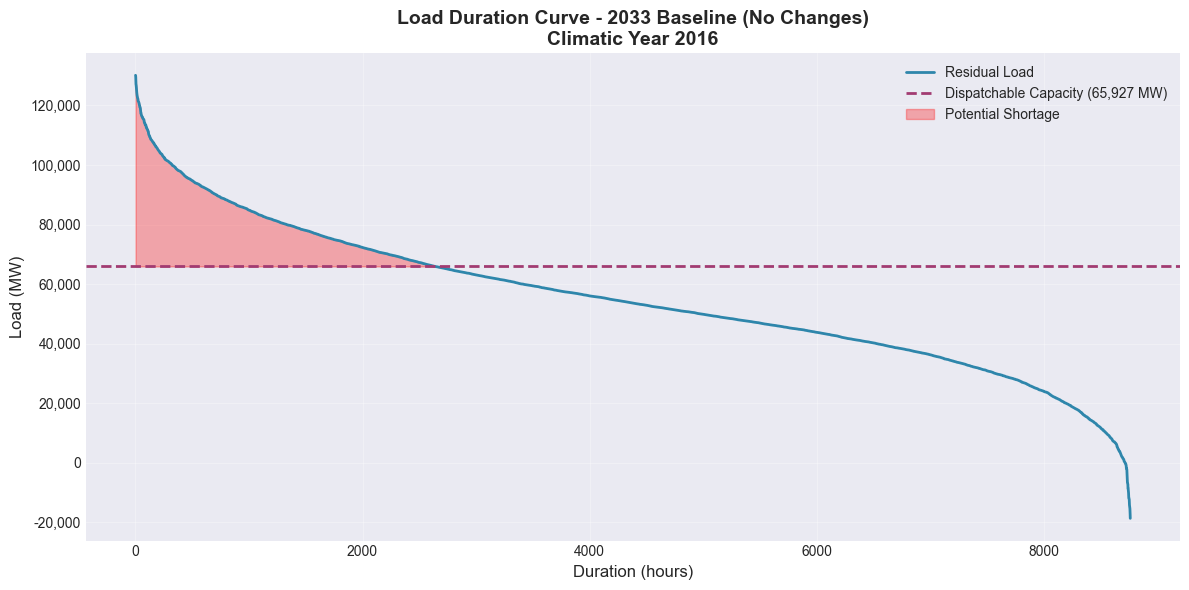

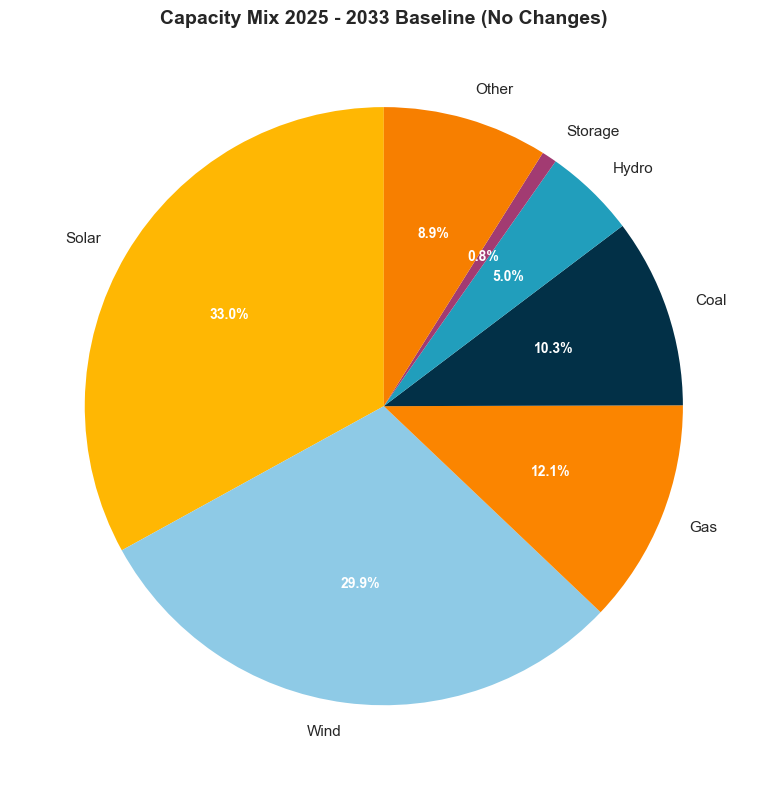

In [8]:
# Visualize baseline scenario
fig1 = plot_load_duration_curve(baseline_analyzer)
plt.show()

fig2 = plot_capacity_mix_pie(baseline_scenario, year=2025)
plt.show()


### Example 2: Coal Phase-Out Scenario

Now let's model a scenario where Germany phases out all coal by 2033 and compensates with gas and renewables.


In [9]:
# Example 2: Coal Phase-Out Scenario
coal_phaseout = CapacityScenario(name="Coal Phase-Out 2033")

# Phase out coal
coal_phaseout.set_absolute_capacity('Hard Coal', 0)
coal_phaseout.set_absolute_capacity('Lignite', 0)

# Add gas capacity to compensate (conservative replacement)
coal_phaseout.set_capacity_adjustment('Gas ', +10000)  # +10 GW

# Add more renewables
coal_phaseout.set_capacity_adjustment('Solar PV', +30000)  # +30 GW
coal_phaseout.set_capacity_adjustment('Wind Onshore', +20000)  # +20 GW
coal_phaseout.set_capacity_adjustment('Wind Offshore', +15000)  # +15 GW

# Analyze
coal_phaseout_analyzer = ScenarioAnalyzer(coal_phaseout, climatic_year=2016, target_year=2033)
coal_phaseout_analyzer.print_summary()

# Show what changed
print("\n" + "="*60)
print("CAPACITY CHANGES FROM BASELINE:")
print("="*60)
summary_df = coal_phaseout.get_summary()
# Filter to only show technologies with changes
changed = summary_df[summary_df['Change (MW)'] != 0].copy()
print(changed.to_string(index=False))



Scenario Analysis: Coal Phase-Out 2033
Climatic Year: 2016 | Target Year: 2033

DEMAND & GENERATION:
  Peak Demand:                 146,589 MW
  Peak Residual Demand:        126,855 MW
  Min Residual Demand:         -57,822 MW
  Renewable Penetration:          53.1 %

CAPACITY & ADEQUACY:
  Dispatchable Capacity:        38,454 MW
  Capacity Margin:             -88,401 MW (-69.7%)

RELIABILITY:
  Shortage Hours:                4,662 hrs
  Unmet Energy:             108,797,218 MWh
  Excess Hours:                    788 hrs
  Total Excess Energy:      10,889,940 MWh

⚠ Warning: 4662 hours with potential shortages

CAPACITY CHANGES FROM BASELINE:
   Technology  2025 Baseline (MW)  2033 Target (MW)  Change (MW)  Change (%)
         Gas             32541.30          42541.30     10000.00   30.730180
    Hard Coal            12786.24              0.00    -12786.24 -100.000000
      Lignite            14687.00              0.00    -14687.00 -100.000000
     Solar PV            88447.85       

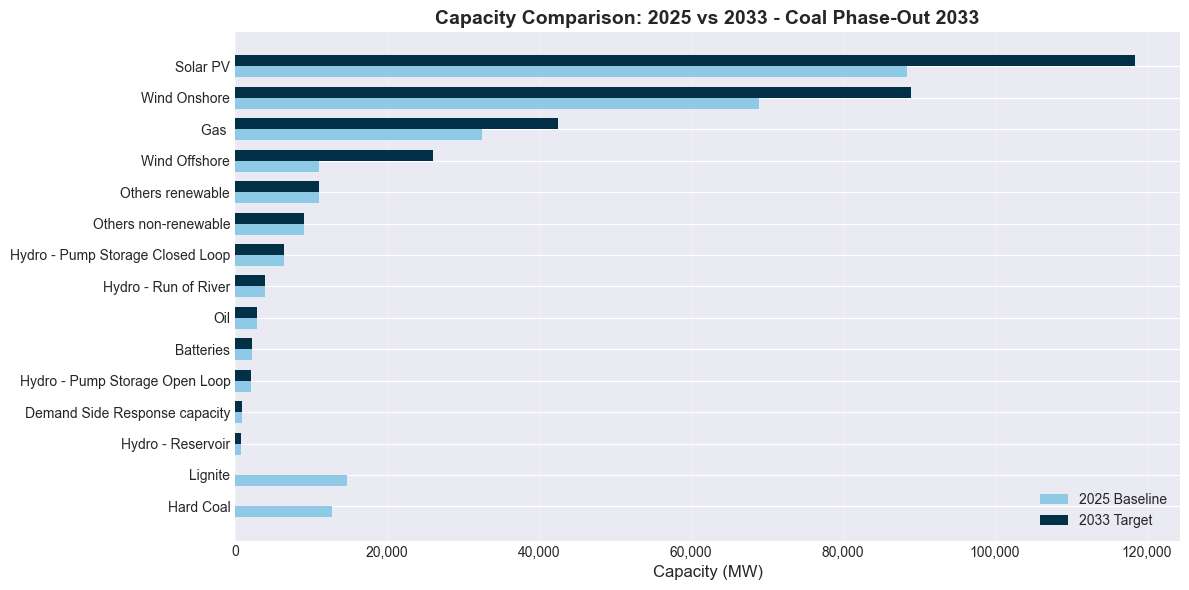

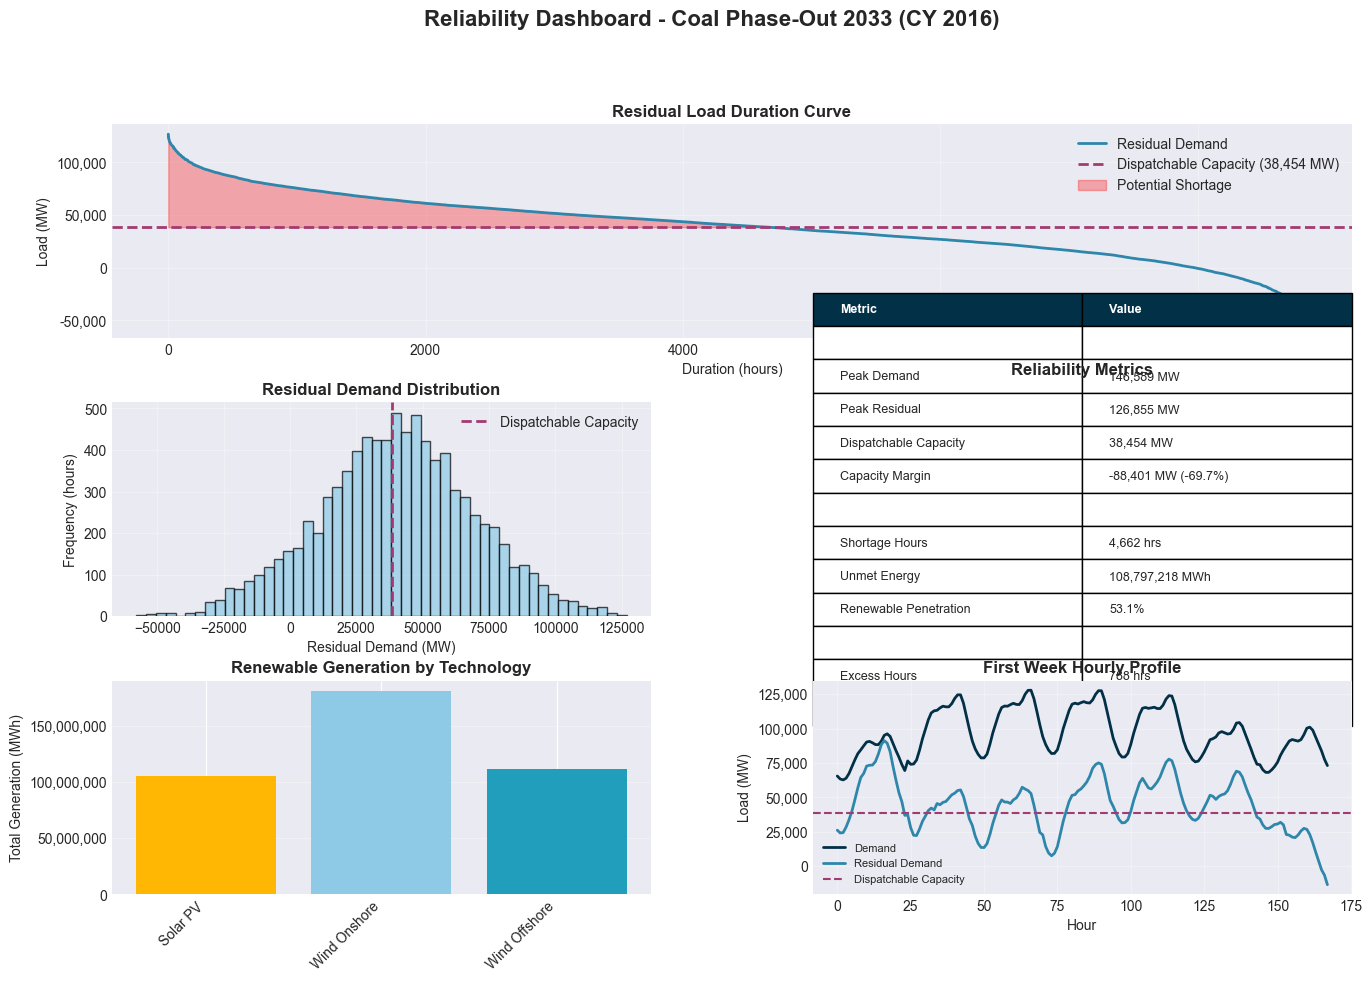

In [10]:
# Visualize coal phase-out scenario
fig1 = plot_capacity_comparison(coal_phaseout)
plt.show()

fig2 = plot_reliability_dashboard(coal_phaseout_analyzer, figsize=(16, 10))
plt.show()


### Example 3: Aggressive Renewable Scenario

A more aggressive renewable expansion with minimal gas backup.



Scenario Analysis: Aggressive Renewables 2033
Climatic Year: 2016 | Target Year: 2033

DEMAND & GENERATION:
  Peak Demand:                 146,589 MW
  Peak Residual Demand:        123,575 MW
  Min Residual Demand:         -96,942 MW
  Renewable Penetration:          70.6 %

CAPACITY & ADEQUACY:
  Dispatchable Capacity:        35,633 MW
  Capacity Margin:             -87,942 MW (-71.2%)

RELIABILITY:
  Shortage Hours:                3,547 hrs
  Unmet Energy:             82,728,100 MWh
  Excess Hours:                  2,052 hrs
  Total Excess Energy:      48,010,763 MWh

⚠ Warning: 3547 hours with potential shortages


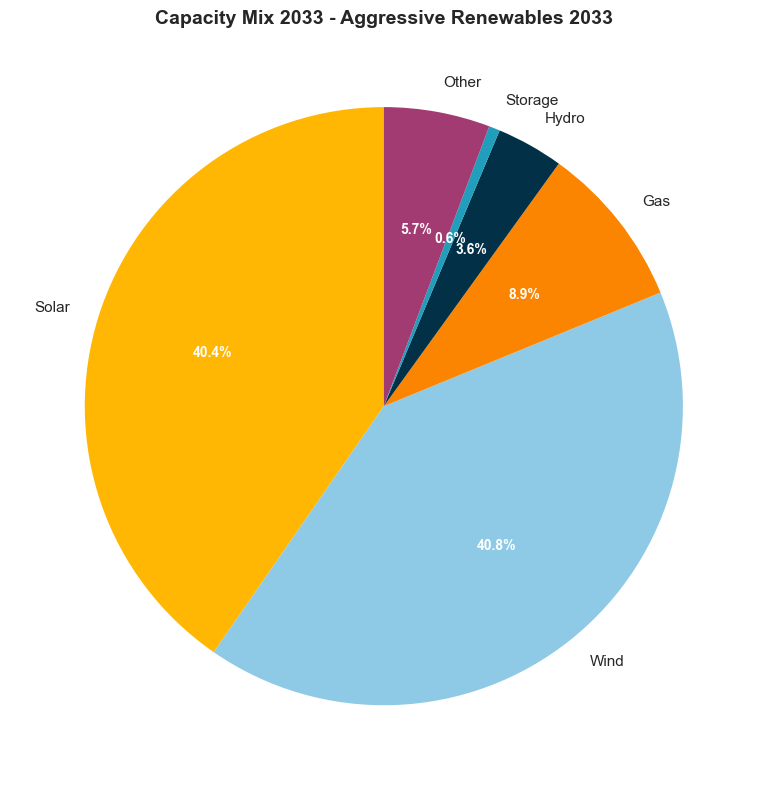

In [11]:
# Example 3: Aggressive Renewable Scenario
aggressive_ren = CapacityScenario(name="Aggressive Renewables 2033")

# Phase out all fossil fuels
aggressive_ren.set_absolute_capacity('Hard Coal', 0)
aggressive_ren.set_absolute_capacity('Lignite', 0)
aggressive_ren.set_absolute_capacity('Oil', 0)

# Keep gas for flexibility but don't expand
# Gas stays at baseline

# Massive renewable expansion
aggressive_ren.set_capacity_adjustment('Solar PV', +60000)  # +60 GW
aggressive_ren.set_capacity_adjustment('Wind Onshore', +40000)  # +40 GW
aggressive_ren.set_capacity_adjustment('Wind Offshore', +30000)  # +30 GW

# Analyze
aggressive_ren_analyzer = ScenarioAnalyzer(aggressive_ren, climatic_year=2016, target_year=2033)
aggressive_ren_analyzer.print_summary()

# Visualize
fig = plot_capacity_mix_pie(aggressive_ren, year=2033, figsize=(10, 8))
plt.show()


### Example 4: Comparing Multiple Scenarios Across Climatic Years

Let's compare how our scenarios perform across different weather conditions (climatic years).


In [12]:
# Example 4: Multi-scenario comparison
# Test coal phase-out across different climatic years

analyzers_list = []

for cy in [2016, 2017, 2018]:
    analyzer = ScenarioAnalyzer(coal_phaseout, climatic_year=cy, target_year=2033)
    analyzers_list.append(analyzer)
    print(f"Climatic Year {cy}:")
    metrics = analyzer.get_reliability_metrics()
    print(f"  Peak Residual: {metrics['peak_residual_mw']:,.0f} MW")
    print(f"  Shortage Hours: {metrics['shortage_hours']:,.0f}")
    print(f"  Renewable Penetration: {metrics['renewable_penetration_pct']:.1f}%")
    print()

# Compare visually
fig = plot_multi_scenario_comparison(analyzers_list, figsize=(16, 6))
plt.show()


Climatic Year 2016:
  Peak Residual: 126,855 MW
  Shortage Hours: 4,662
  Renewable Penetration: 53.1%

Climatic Year 2017:


ValueError: zero-size array to reduction operation maximum which has no identity

### Example 5: Comparing Different Policy Scenarios

Compare baseline, coal phase-out, and aggressive renewable scenarios side by side.


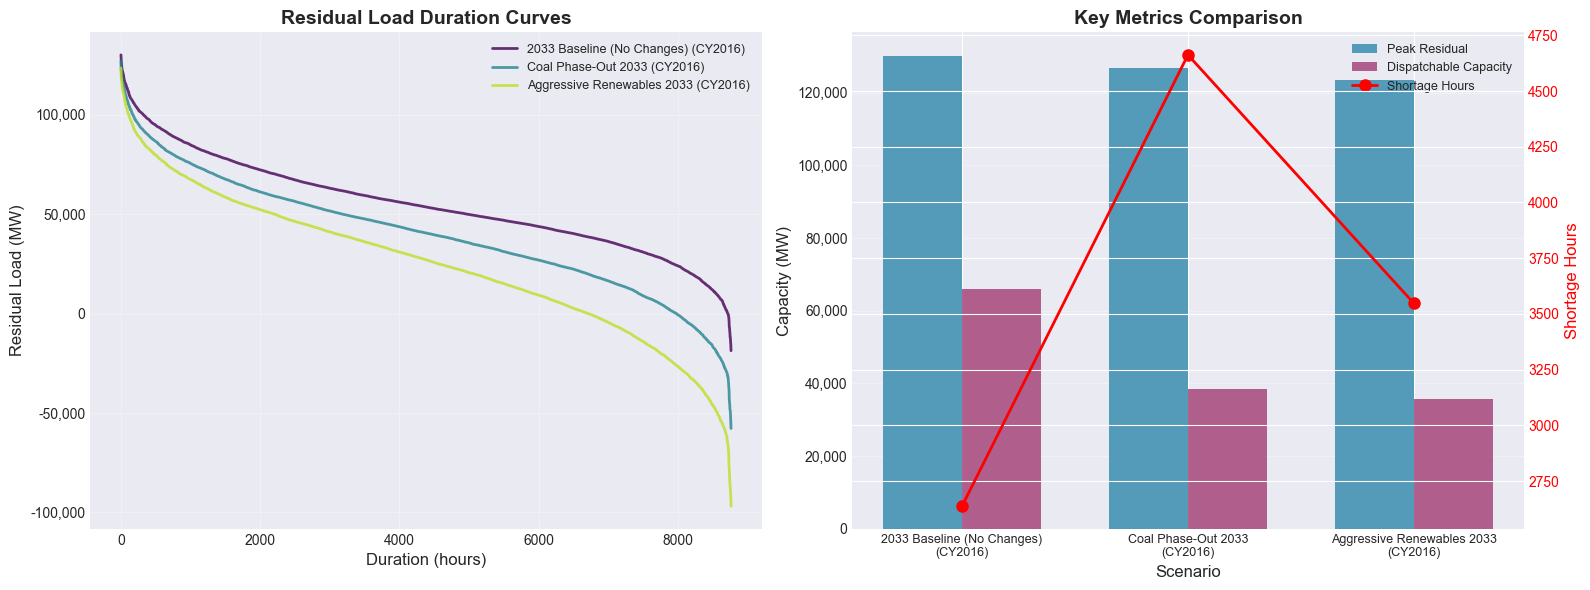


SCENARIO COMPARISON - CLIMATIC YEAR 2016
                  Scenario Dispatchable (GW) Variable RES (GW) Total (GW) Peak Residual (GW) Capacity Margin (%) Shortage Hours RES Penetration (%)
2033 Baseline (No Changes)              65.9             168.6      234.5              130.1               -49.3          2,637                35.5
       Coal Phase-Out 2033              38.5             233.6      272.0              126.9               -69.7          4,662                53.1
Aggressive Renewables 2033              35.6             298.6      334.2              123.6               -71.2          3,547                70.6


In [ ]:
# Example 5: Policy scenario comparison
# Use same climatic year for fair comparison
cy = 2016

policy_analyzers = [
    ScenarioAnalyzer(baseline_scenario, climatic_year=cy, target_year=2033),
    ScenarioAnalyzer(coal_phaseout, climatic_year=cy, target_year=2033),
    ScenarioAnalyzer(aggressive_ren, climatic_year=cy, target_year=2033)
]

# Create comparison plot
fig = plot_multi_scenario_comparison(policy_analyzers, figsize=(16, 6))
plt.show()

# Print detailed comparison table
print("\n" + "="*80)
print("SCENARIO COMPARISON - CLIMATIC YEAR 2016")
print("="*80)

comparison_data = []
for analyzer in policy_analyzers:
    metrics = analyzer.get_reliability_metrics()
    cap_totals = analyzer.scenario.get_total_capacity_by_type(2033)
    
    comparison_data.append({
        'Scenario': analyzer.scenario.name,
        'Dispatchable (GW)': f"{cap_totals['dispatchable']/1000:.1f}",
        'Variable RES (GW)': f"{cap_totals['variable_renewables']/1000:.1f}",
        'Total (GW)': f"{cap_totals['total']/1000:.1f}",
        'Peak Residual (GW)': f"{metrics['peak_residual_mw']/1000:.1f}",
        'Capacity Margin (%)': f"{metrics['capacity_margin_pct']:.1f}",
        'Shortage Hours': f"{metrics['shortage_hours']:,.0f}",
        'RES Penetration (%)': f"{metrics['renewable_penetration_pct']:.1f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))


## Interactive Mode - Try It Yourself!

Now it's your turn! Use the interactive interface to explore different capacity planning scenarios.

Run the cell below to launch the interactive planner.


In [ ]:
# Launch the interactive capacity planner
planner = InteractiveCapacityPlanner(base_scenario_name="My Custom Scenario")
planner.display()


## Understanding Load Duration Curves

### What is a Load Duration Curve?

A **Load Duration Curve (LDC)** is a fundamental tool in power system planning. It's created by:
1. Taking all hourly load values for a year (8760 hours)
2. Sorting them from highest to lowest
3. Plotting them against duration

### Key Insights from LDCs:

**Peak Load Region (left side):**
- Shows maximum demand the system must meet
- Occurs only a few hours per year
- Drives "peaking capacity" needs

**Baseload Region (right side):**
- Shows minimum sustained demand
- Occurs most of the year
- Suitable for constant generation sources

**Middle Region:**
- Variable demand requiring flexible generation
- Where dispatchable capacity is most valuable

### Residual Load Duration Curve

When we subtract variable renewable generation (solar, wind) from demand, we get the **residual load**:

`Residual Load = Demand - Wind Generation - Solar Generation`

This is what **dispatchable** capacity (gas, hydro, storage) must cover. The residual LDC tells us:
- How much dispatchable capacity we need
- When shortages might occur
- Hours with excess renewable generation (negative residual)

### Interpreting the Charts

**If residual load > dispatchable capacity:**
- Potential shortage
- May need more capacity or demand response
- Risk of reliability issues

**If residual load < 0:**
- Excess renewable generation
- Opportunity for storage or export
- Possible curtailment

### Capacity Margin

The difference between available dispatchable capacity and peak residual load:

`Capacity Margin = Dispatchable Capacity - Peak Residual Load`

A positive margin indicates the system can meet peak residual demand. Typical targets: 15-20% margin for reliability.


## Advanced Usage: Custom Scenarios

You can also create scenarios programmatically for more complex analyses.


In [ ]:
# Advanced Example: Sensitivity Analysis on Solar Capacity

# Create multiple scenarios with varying solar capacity
solar_capacities = [90000, 120000, 150000, 180000]  # MW
sensitivity_analyzers = []

for solar_cap in solar_capacities:
    scenario = CapacityScenario(name=f"Solar {solar_cap/1000:.0f} GW")
    
    # Phase out coal
    scenario.set_absolute_capacity('Hard Coal', 0)
    scenario.set_absolute_capacity('Lignite', 0)
    
    # Set solar capacity
    scenario.set_absolute_capacity('Solar PV', solar_cap)
    
    # Add some wind
    scenario.set_capacity_adjustment('Wind Onshore', +25000)
    scenario.set_capacity_adjustment('Wind Offshore', +20000)
    
    # Analyze
    analyzer = ScenarioAnalyzer(scenario, climatic_year=2016, target_year=2033)
    sensitivity_analyzers.append(analyzer)

# Compare results
print("Solar Capacity Sensitivity Analysis")
print("="*80)
for analyzer in sensitivity_analyzers:
    metrics = analyzer.get_reliability_metrics()
    solar_cap = analyzer.scenario.get_capacity('Solar PV', 2033)
    print(f"\nSolar Capacity: {solar_cap/1000:.0f} GW")
    print(f"  Peak Residual: {metrics['peak_residual_mw']/1000:.1f} GW")
    print(f"  Shortage Hours: {metrics['shortage_hours']:,.0f}")
    print(f"  Renewable Penetration: {metrics['renewable_penetration_pct']:.1f}%")
    print(f"  Excess Hours: {metrics['excess_hours']:,.0f}")

# Plot comparison
fig = plot_multi_scenario_comparison(sensitivity_analyzers, figsize=(16, 6))
plt.show()


## Summary & Next Steps

### What You've Learned

1. **Load Duration Curves**: How to interpret and use them for capacity planning
2. **Residual Load**: Understanding what dispatchable capacity must cover
3. **Scenario Analysis**: Modeling different capacity expansion paths
4. **Reliability Metrics**: Evaluating system adequacy

### Key Takeaways

- **Coal phase-out** requires significant renewable expansion or gas backup
- **Climatic years** (weather scenarios) significantly impact system reliability
- **Capacity margin** is crucial for system adequacy
- **Variable renewables** reduce residual load but create new challenges (negative residual = curtailment)

### Next Steps

1. **Iterate on scenarios**: Use the interactive interface to explore more options
2. **Test extreme weather**: Analyze worst-case climatic years
3. **Consider storage**: Future versions could model battery storage explicitly
4. **Economic analysis**: Add cost considerations to capacity decisions
5. **Multi-year pathways**: Model gradual transitions from 2025 to 2033

### Data Sources

- **Demand Data**: ERAA 2023-2 demand projections for Germany
- **Capacity Factors**: ERAA 2023-2 renewable generation profiles
- **Generation Capacity**: ERAA 2023-2 baseline capacity data

### Tool Extensibility

The tool is designed to be extensible:
- Add new technologies to `CapacityScenario.VARIABLE_RENEWABLES` or `DISPATCHABLE`
- Extend `ScenarioAnalyzer` with new metrics
- Create custom visualization functions
- Model interconnection with neighboring countries

---

**Enjoy exploring Germany's energy transition scenarios!**


## Quick Reference

### Classes

- **`CapacityScenario`**: Manages generation capacity portfolio
  - `set_absolute_capacity(tech, mw)`: Set target capacity for a technology
  - `set_capacity_adjustment(tech, delta_mw)`: Adjust capacity by delta
  - `get_summary()`: Get DataFrame of capacity changes
  
- **`ScenarioAnalyzer`**: Analyzes a scenario for a climatic year
  - `get_load_duration_curve(data_type)`: Get LDC data
  - `get_reliability_metrics()`: Get dict of reliability metrics
  - `print_summary()`: Print analysis summary
  
- **`InteractiveCapacityPlanner`**: Interactive UI for scenario exploration
  - `display()`: Show interactive interface

### Key Functions

- `plot_load_duration_curve(analyzer)`: Plot LDC with capacity overlay
- `plot_capacity_comparison(scenario)`: Compare 2025 vs 2033 capacity
- `plot_reliability_dashboard(analyzer)`: Comprehensive dashboard
- `plot_multi_scenario_comparison(analyzers)`: Compare multiple scenarios

### Available Technologies

**Variable Renewables:**
- Solar PV, Wind Onshore, Wind Offshore, Solar Thermal

**Dispatchable:**
- Gas, Hard Coal, Lignite, Hydro (various), Batteries, Others

### Typical Workflow

```python
# 1. Create scenario
scenario = CapacityScenario(name="My Scenario")

# 2. Adjust capacities
scenario.set_absolute_capacity('Hard Coal', 0)  # Phase out coal
scenario.set_capacity_adjustment('Solar PV', +30000)  # Add 30 GW solar

# 3. Analyze
analyzer = ScenarioAnalyzer(scenario, climatic_year=2016, target_year=2033)
analyzer.print_summary()

# 4. Visualize
fig = plot_reliability_dashboard(analyzer)
plt.show()
```
